In [170]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torch.utils.data.sampler import BatchSampler
import utils

In [183]:
import importlib
importlib.reload(cebra2.dataset)
importlib.reload(cebra2.solver)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.criterion)
importlib.reload(utils)

<module 'utils' from '/volatile/aurelien_stumpf_mascles/project/code/utils/__init__.py'>

In [172]:
loaded_arrays = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/SYNTHETIC_database/sub-200_states-4_noise-high_synth/dataset.npz')
print(loaded_arrays.files)

['data25', 'dfc25', 'labels25', 'data30', 'dfc30', 'labels30', 'data35', 'dfc35', 'labels35', 'data40', 'dfc40', 'labels40', 'data45', 'dfc45', 'labels45', 'states']


In [180]:
dfc45 = torch.from_numpy(loaded_arrays['dfc45'])
labels45 = loaded_arrays["labels45"]
data45 = loaded_arrays['data45']

In [182]:
labels45.shape

(200, 455, 45)

In [184]:
labels_with_transition = utils.preprocessing.create_labels_with_transitions(labels45)

In [185]:
labels_with_transition

2.0

In [7]:
def generate_corr_matrix(data,SingleSession = False):
    if SingleSession : 
        n,m,_ = data.shape
        corr_matrix = np.zeros((n,m,m))
        for i in range(n):
            corr_matrix[i,:,:] = np.corrcoef(data[i,:,:])
        corr_matrix = torch.unsqueeze(torch.from_numpy(corr_matrix),dim=2)
    else :
        n,m,p,_ = data.shape
        corr_matrix = np.zeros((n,m,p,p))
        for i in range(n):
            for j in range(m):
                corr_matrix[i,j,:,:] = np.corrcoef(data[i,j,:,:])
        corr_matrix = torch.unsqueeze(torch.from_numpy(corr_matrix),dim=2)
    return corr_matrix

In [8]:
def flatten_higher_triangular(data,SingleSession = False):
    if SingleSession : 
        n,m,_, = data.shape
        res = np.zeros((n,m*(m-1)//2))
        for i in range(n):
            accu = torch.Tensor([])
            for k in range(m-1):
                accu = torch.cat([accu,data[i,k,k+1:]])
            res[i,:] = accu
    else :
        n,m,p,_ = data.shape
        res = np.zeros((n,m,p*(p-1)//2))
        for i in range(n):
            for j in range(m):
                accu = torch.Tensor([])
                for k in range(p-1):
                    accu = torch.cat([accu,data[i,j,k,k+1:]])
                res[i,j,:] = accu
    return res

In [9]:
def generate_matrix_distance(data,SingleSession = True):
    if SingleSession : 
        time,_,_,_ = data.shape
        distance_matrix = np.zeros((time,time)) 
        for t1 in range(time):
            for t2 in range(time):
                distance_matrix[t1,t2] = np.linalg.norm(data[t1,0,:,:] - data[t2,0,:,:])
    else : 
        nb_session,time,_,_ = data.shape
        distance_matrix = np.zeros((nb_session,time,nb_session,time)) 
        for session1 in range(nb_session):
            print(session1)
            for t1 in range(time):
                for session2 in range(nb_session):
                    for t2 in range(time):
                        if session1 == session2 : 
                            distance_matrix[session1,t1,session2,t2] = 0
                        else :
                            distance_matrix[session1,t1,session2,t2] = np.linalg.norm(data[session1,t1,0,:,:] - data[session2,t2,0,:,:])
    return distance_matrix

In [10]:
def generate_vector_distance(data,SingleSession = True,distance = "euclidean"):

    def euclidean_metric(x,y):
        return np.linalg.norm(x - y)
    
    def exponential_metric(x,y):
        return np.exp(np.linalg.norm(x - y)/10)
    
    if distance == "euclidean":
        metric = euclidean_metric
    if distance == "exp":
        metric = exponential_metric

    if SingleSession : 
        time,_ = data.shape
        distance_matrix = np.zeros((time,time)) 
        for t1 in range(time):
            for t2 in range(t1,time):
                accu = metric(data[t1,:],data[t2,:])
                distance_matrix[t1,t2] = accu
                distance_matrix[t2,t1] = accu
    else : 
        nb_session,time,_ = data.shape
        distance_matrix = np.zeros((nb_session,time,nb_session,time)) 
        for session1 in range(nb_session):
            print(session1)
            for t1 in range(time):
                for session2 in range(session1,nb_session):
                    for t2 in range(time):
                        accu = metric(data[session1,t1,:],data[session2,t2,:])
                        distance_matrix[session1,t1,session2,t2] = accu
                        distance_matrix[session2,t2,session1,t1] = accu
    return distance_matrix

In [11]:
fc_train = flatten_higher_triangular(dfc45)
fc_train = fc_train[0:10,:,:]
print(fc_train.shape)

(10, 455, 3321)


In [11]:
distance = torch.from_numpy(generate_vector_distance(fc_train,SingleSession = False,distance="exp"))

0
1
2
3
4
5
6
7
8
9


(array([2.27500e+03, 1.40000e+01, 1.50000e+03, 2.94600e+03, 2.28600e+03,
        2.89800e+03, 3.12400e+03, 3.37200e+03, 3.57400e+03, 3.75200e+03,
        3.98600e+03, 4.05000e+03, 4.25200e+03, 4.30000e+03, 4.42200e+03,
        4.48800e+03, 4.55800e+03, 4.64000e+03, 4.73400e+03, 4.73200e+03,
        4.76800e+03, 4.81000e+03, 4.83200e+03, 4.91000e+03, 4.94400e+03,
        4.93200e+03, 4.85400e+03, 4.93200e+03, 5.46000e+03, 7.26600e+03,
        1.11140e+04, 1.59360e+04, 1.92960e+04, 2.19480e+04, 2.37500e+04,
        3.02140e+04, 5.14440e+04, 8.13300e+04, 1.06188e+05, 1.24068e+05,
        1.39918e+05, 1.61892e+05, 1.75968e+05, 1.77750e+05, 1.75438e+05,
        1.80422e+05, 1.90178e+05, 1.98844e+05, 2.07218e+05, 2.04510e+05,
        1.96024e+05, 1.95716e+05, 1.97050e+05, 1.96130e+05, 1.82760e+05,
        1.68382e+05, 1.58378e+05, 1.52084e+05, 1.37586e+05, 1.25138e+05,
        1.13196e+05, 1.03010e+05, 9.09040e+04, 8.39900e+04, 7.84020e+04,
        7.26460e+04, 6.71740e+04, 5.84060e+04, 5.16

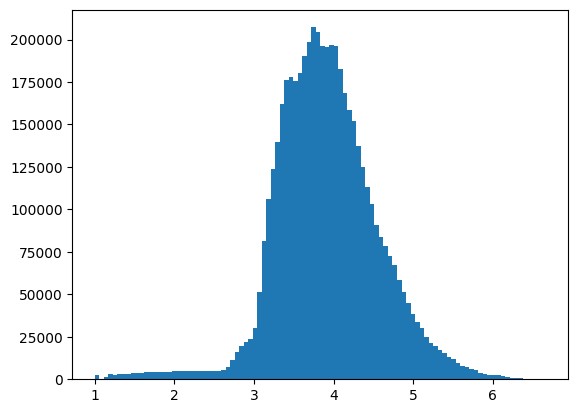

In [86]:
plt.hist(distance.flatten(),bins=100)

In [12]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

In [13]:
@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

In [15]:
num_output = 3
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        num_output * 1000,
    ),
    nn.GELU(),
    nn.Linear(int(num_output * 1000), num_output * 200),
    nn.GELU(),
    nn.Linear(int(num_output * 200), num_output * 60),
    nn.GELU(),
    nn.Linear(int(num_output * 60), num_output * 30),
    nn.GELU(),
    nn.Linear(int(num_output * 30), num_output),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [16]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 2048,  distance = distance, time_delta = 20, matrix_delta = 4)

NameError: name 'distance' is not defined

In [ ]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [31]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 3.3123, Train accuracy 0.00%
Epoch 100
Train loss 3.2452, Train accuracy 0.00%
Epoch 200
Train loss 3.2384, Train accuracy 0.00%
Epoch 300
Train loss 3.2401, Train accuracy 0.00%
Epoch 400
Train loss 3.2380, Train accuracy 0.00%


KeyboardInterrupt: 

In [23]:
a,b,c = fc_dataset.neural.shape
data_print = fc_dataset.neural.reshape(a*b,c)
labels_print = labels_with_transition[0:10,:].reshape(a*b)
fc_emb = _compute_emissions_single(cebra_fc, data_print)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
ax1.scatter(fc_emb[:,0], fc_emb[:,1], cmap = matplotlib.colors.ListedColormap(colors), c = labels_print, s=1)
#ax1.xticks() 
ax1.axis('on')

NameError: name 'cebra_fc' is not defined

In [23]:
fc_emb.shape

(4550, 3)

Comparaison des matrices de connectivité moyennes avec les true labels

In [97]:
states = torch.from_numpy(loaded_arrays['states'])
states_preprocessed = torch.from_numpy(flatten_higher_triangular(states,SingleSession = True)).type(torch.float32)
states_emb = _compute_emissions_single(cebra_fc, states_preprocessed)

(-1.06568386554718, 1.0790733337402343, -0.990953129529953, 1.0889645040035247)

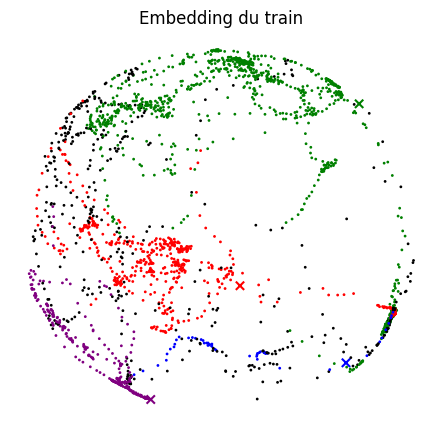

In [99]:
fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ['black','red','green','blue','purple']
ax1.scatter(states_emb[:,1], states_emb[:,2], cmap = matplotlib.colors.ListedColormap(colors[1:]), c = [1,2,3,4], marker = "x")
ax1.scatter(fc_emb[:,1], fc_emb[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = labels_print, s=1)
ax1.axis('off')

Entraînement d'un classifieur sur l'espace latent

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=3, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=4)
        self.fc3 = nn.LogSoftmax(dim=1)
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x 

In [87]:
class SimpleDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = torch.from_numpy(X).type(torch.float32)
        self.y = torch.from_numpy(y).type(torch.int64) - 1 #F.one_hot(torch.from_numpy(y-1).type(dtype=torch.int64), num_classes=4)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        batch = self.X[idx]
        targets = self.y[idx]

        return batch,targets


class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, dataset, n_classes, n_samples):
        loader = torch.utils.data.DataLoader(dataset)
        self.labels_list = []
        for _, label in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size

In [107]:
net = MLP()
X = fc_emb[labels_print > 0]
y = labels_print[labels_print > 0]
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train = SimpleDataset(X_train,y_train)
test = SimpleDataset(X_test,y_test)
train_loader = torch.utils.data.DataLoader(train, batch_size=1000, shuffle=True, num_workers=6)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True, num_workers=6)

In [160]:
# === Train === ###
def Train(net,train_loader,test_loader,nb_epochs):
    net.train()
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    batch_size = train_loader.batch_sampler.n_samples * train_loader.batch_sampler.n_classes

    # train loop
    for epoch in range(nb_epochs):
        train_correct = 0
        train_loss = 0
        compteur = 0
        
        # loop per epoch 
        for i, (batch, targets) in enumerate(train_loader):

            output = net(batch)

            loss = criterion(output, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = output.max(1, keepdim=True)[1]
            train_correct += pred.eq(targets.view_as(pred)).sum().item()
            train_loss += loss

            compteur += 1

        if epoch % 10 == 0: 
            print('Train loss {:.4f}, Train accuracy {:.2f}%'.format(
            train_loss / (compteur * batch_size), 100 * train_correct / (compteur * batch_size)))

            # loop, over whole test set
            compteur_batch = 0
            net.eval()
            test_correct = 0

            for i, (batch, targets) in enumerate(test_loader):
                
                output = net(batch)
                pred = output.max(1, keepdim=True)[1]
                test_correct += pred.eq(targets.view_as(pred)).sum().item()
                compteur_batch+=1
                
            print('Test accuracy {:.2f}%'.format(
                100 * test_correct / (test_loader.batch_size * compteur_batch)))
            
            net.train()
            
    print('End of training.\n')
    
# === Test === ###
def Test(net,test):
    test_correct = 0
    net.eval()

    # loop, over whtorch.float32t(batch)
    pred = output.max(1, keepdim=True)[1]
    test_correct += pred.eq(targets.view_as(pred)).sum().item()
        
    print('End of testing. Test accuracy {:.2f}%'.format(
        100 * test_correct / (len(test_loader) * 64)))

In [109]:
Train(net,train_loader,test_loader,100)

Train loss 0.0014, Train accuracy 20.40%
End of testing. Test accuracy 18.00%
Train loss 0.0013, Train accuracy 20.50%
End of testing. Test accuracy 19.90%
Train loss 0.0012, Train accuracy 20.50%
End of testing. Test accuracy 19.90%
Train loss 0.0011, Train accuracy 29.45%
End of testing. Test accuracy 32.90%
Train loss 0.0008, Train accuracy 46.75%
End of testing. Test accuracy 43.50%
Train loss 0.0006, Train accuracy 46.80%
End of testing. Test accuracy 43.40%
Train loss 0.0005, Train accuracy 46.10%
End of testing. Test accuracy 42.50%
Train loss 0.0005, Train accuracy 45.50%
End of testing. Test accuracy 42.30%
Train loss 0.0005, Train accuracy 45.45%
End of testing. Test accuracy 42.30%
Train loss 0.0005, Train accuracy 45.15%
End of testing. Test accuracy 43.20%
End of training.



Utilisation d'une PCA

In [19]:
fc_train.shape

(10, 455, 3321)

In [20]:
a,b,c = fc_train.shape
pca = PCA(n_components=4)
pca.fit(fc_train.reshape(a*b,c))

PCA(n_components=4)

In [21]:
fc_transformed = torch.zeros((a,b,4))
for i in range(a):
    fc_transformed[i,:,:] = torch.from_numpy(pca.transform(fc_train[i,:,:]))

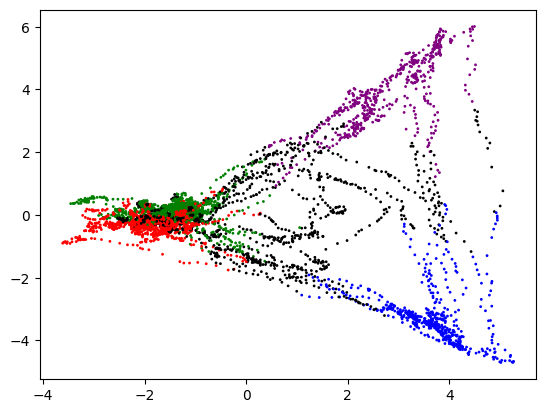

In [26]:
accu = fc_transformed.reshape((a*b,4))
colors = ["black",'red','green','blue','purple']
plt.scatter(accu[:,1], accu[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = labels_print, s=1)

In [27]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(in_features=4, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=4)
        self.fc3 = nn.LogSoftmax(dim=1)
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x 

In [28]:
net = MLP2()
a,b,c = fc_transformed.shape
X = fc_transformed.reshape((a*b,c))[labels_print > 0].numpy()
y = labels_print[labels_print > 0]
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train = SimpleDataset(X_train,y_train)
test = SimpleDataset(X_test,y_test)
train_loader = torch.utils.data.DataLoader(train, batch_size=1000, shuffle=True, num_workers=6)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True, num_workers=6)

In [29]:
Train(net,train_loader,test_loader,500)

Train loss 0.0014, Train accuracy 26.83%
Test accuracy 29.35%
Train loss 0.0007, Train accuracy 64.10%
Test accuracy 46.35%
Train loss 0.0006, Train accuracy 65.17%
Test accuracy 47.55%
Train loss 0.0006, Train accuracy 65.47%
Test accuracy 47.60%
Train loss 0.0006, Train accuracy 65.50%
Test accuracy 47.60%
Train loss 0.0006, Train accuracy 65.50%
Test accuracy 47.60%


KeyboardInterrupt: 

In [30]:
num_output = 3
normalize = True
num_neurons = 4

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        num_output * 5,
    ),
    nn.GELU(),
    nn.Linear(int(num_output * 5), num_output * 3),
    nn.GELU(),
    nn.Linear(int(num_output * 3), num_output),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [31]:
fc_transformed.shape

torch.Size([10, 455, 4])

In [32]:
distance = torch.from_numpy(generate_vector_distance(fc_transformed,SingleSession = False,distance="euclidean"))

0
1
2
3
4
5
6
7
8
9


(array([  590.,   932.,  1528.,  2692.,  4270.,  5762.,  6762.,  8064.,
         8700.,  9975., 11094., 11130., 12027., 12530., 13019., 12970.,
        13301., 13705., 14608., 15538., 16417., 16996., 17164., 16462.,
        15336., 14529., 13820., 12815., 12810., 12881., 12714., 11983.,
        11914., 12184., 12284., 12711., 12610., 12726., 12364., 12403.,
        12285., 12433., 12521., 13273., 13839., 14061., 14251., 14552.,
        14731., 14843., 15129., 16350., 16985., 17435., 17748., 18251.,
        18520., 18868., 18427., 17611., 16649., 15702., 15506., 15029.,
        14609., 14372., 13781., 13335., 12664., 11685., 11132., 10052.,
         9084.,  8117.,  7033.,  6488.,  5780.,  5005.,  4041.,  3044.,
         2708.,  2605.,  2456.,  1920.,  1601.,  1359.,  1156.,  1225.,
         1231.,  1095.,  1078.,  1260.,  1088.,   768.,   368.,   196.,
          106.,   127.,    90.,    22.]),
 array([ 0.        ,  0.11676248,  0.23352495,  0.35028743,  0.4670499 ,
         0.58381238, 

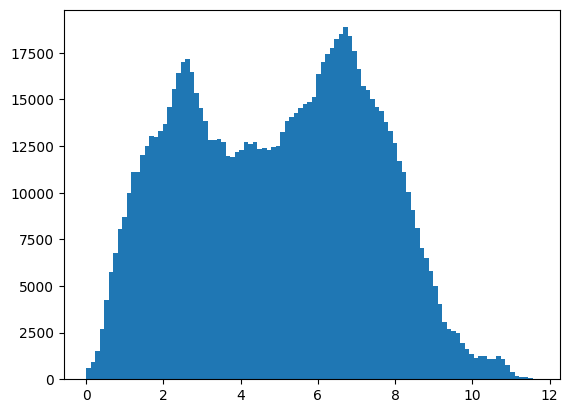

In [33]:
plt.hist(distance.flatten()[:1000000],bins=100)

In [34]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_transformed)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 2048,  distance = distance, time_delta = 20, matrix_delta = 4)

In [35]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [36]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 7.5177, Train accuracy 0.00%
Epoch 100
Train loss 7.2485, Train accuracy 0.00%
Epoch 200
Train loss 7.0762, Train accuracy 0.00%
Epoch 300
Train loss 7.0107, Train accuracy 0.00%
Epoch 400
Train loss 6.9748, Train accuracy 0.00%
Epoch 500
Train loss 6.9684, Train accuracy 0.00%
Epoch 600
Train loss 6.9604, Train accuracy 0.00%
Epoch 700
Train loss 6.9719, Train accuracy 0.00%
Epoch 800
Train loss 6.9522, Train accuracy 0.00%
Epoch 900
Train loss 6.9588, Train accuracy 0.00%


(-1.0990591496229172,
 1.0992888063192368,
 -1.0790404468774795,
 1.0984484940767287)

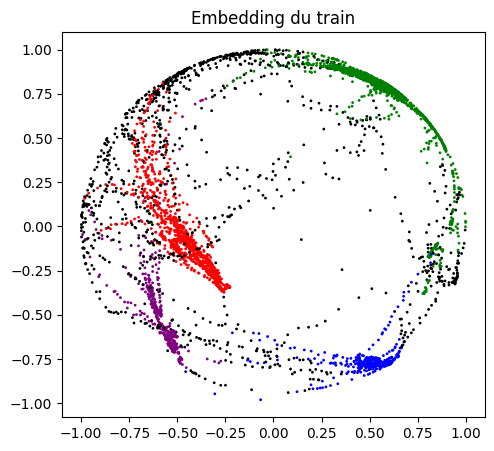

In [40]:
a,b,c = fc_dataset.neural.shape
data_print = fc_dataset.neural.reshape(a*b,c)
labels_print = labels_with_transition[0:10,:].reshape(a*b)
fc_emb = _compute_emissions_single(cebra_fc, data_print)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
ax1.scatter(fc_emb[:,0], fc_emb[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = labels_print, s=1)
#ax1.xticks() 
ax1.axis('on')

In [132]:
class MLP3(nn.Module):
    def __init__(self):
        super(MLP3, self).__init__()
        self.fc1 = nn.Linear(in_features=3, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=4)
        self.fc4 = nn.LogSoftmax(dim=1)
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x 

In [145]:
labels = labels_with_transition[0:10,:]
a,b = labels.shape
#labels = labels.reshape((a*b))

In [142]:
np.unique(labels,return_counts=True)

(array([0., 1., 2., 3., 4.]), array([1097, 1070, 1290,  562,  531]))

In [146]:
labels[0,:]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [167]:
net = MLP3()
labels = labels_with_transition[0:10,:]
a,b = labels.shape
labels = labels.reshape((a*b))
X = fc_emb[labels > 0]
y = labels_print[labels_print > 0]
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = SimpleDataset(X_train,y_train)
test = SimpleDataset(X_test,y_test)
balanced_batch_sampler = BalancedBatchSampler(train, n_classes = 4, n_samples = 4)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True, num_workers=6)

In [168]:
Train(net,train_loader,test_loader,100)

Train loss 0.0107, Train accuracy 97.09%
Test accuracy 68.80%
Train loss 0.0003, Train accuracy 99.82%
Test accuracy 68.90%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 69.00%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 69.00%


KeyboardInterrupt: 

In [163]:
a,b = np.meshgrid(np.linspace(0,2*np.pi,300),np.linspace(0,np.pi,200))
x = (np.cos(a)*np.cos(b)).reshape(-1,1)
y = (np.sin(a)*np.cos(b)).reshape(-1,1)
z = np.sin(b).reshape(-1,1)
sphere = np.concatenate((x,y,z),axis = 1)


In [164]:
net.eval()
probas = torch.exp(net(torch.from_numpy(sphere).type(torch.float32)))
res = torch.argmax(probas,dim=1)+1

In [165]:
torch.unique(res)

tensor([1, 2, 3, 4])

(-1.0990591496229172,
 1.0992888063192368,
 -1.0385494887828828,
 1.0915063083171845)

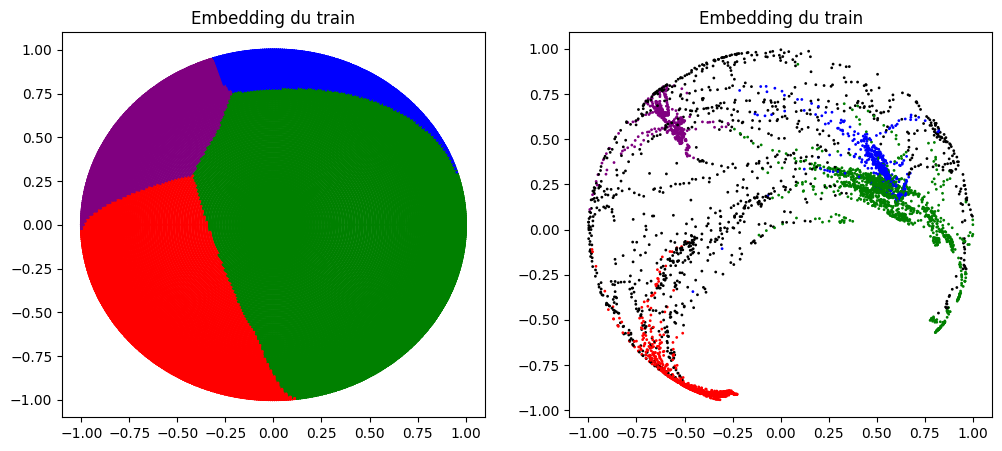

In [166]:
fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
ax1.scatter(sphere[:,0], sphere[:,1], cmap = matplotlib.colors.ListedColormap(colors[1:]), c = res, s=1)
#ax1.xticks() 
ax1.axis('on')

ax2 = plt.subplot(122)
ax2.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
ax2.scatter(fc_emb[:,0], fc_emb[:,1], cmap = matplotlib.colors.ListedColormap(colors), c = labels_print, s=1)
#ax1.xticks() 
ax2.axis('on')